In [1]:
from ase.io import read
import numpy as np
import sys
from matplotlib import pyplot as plt

import joblib
import pickle
sys.path.insert(0,"../")
from castle import train_ensamble_linear_model, ASEMLCalculator, AceGlobalRepresentation, train_linear_model
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

def split_dataset(N, training_percentage, seed=20):
    np.random.seed(seed)
    ids = list(range(N))
    np.random.shuffle(ids)
    return ids[:int(training_percentage*N)], ids[int(training_percentage*N):]

%load_ext autoreload
%autoreload 2

/home/claudio/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [2]:
# Load xyz data
input_file =  "/home/claudio/postdoc/integrated_potentials/data/Si_2018/delta_silicon.xyz"
frames_ = read(input_file, index = ':')
    
# Wrap positions so rascal does not complain
for ff in frames_:
    ff.wrap(eps=1e-11)
energy_name = 'dft_energy'
force_name = 'dft_force'
virial_name = 'dft_virial'


tags = set()
for ff in frames_:
    tags.add(ff.info['config_type'])
print(tags)

# build a potential for diamond phase only
frames = []
for ff in frames_:
    if ff.info['config_type'] in ['amorph', 'bt', 'dia', 'liq', 'fcc', 'bcc', 'hcp', 'hex_diamond']:
        try:
            len(ff.info['dft_virial'])
            frames.append(ff)
        except KeyError:
            pass
        
        
# Create training and validation set
tr_ind, val_ind = split_dataset(len(frames), 0.8)
tr_frames = [frames[s] for s in tr_ind]
val_frames = [frames[s] for s in val_ind]
e_t, f_t = get_forces_and_energies(tr_frames, energy_name = energy_name, force_name = force_name)
e_val, f_val = get_forces_and_energies(val_frames, energy_name = energy_name, force_name = force_name)
s_val = get_virials(val_frames, virial_name)
nat_val = get_nat(val_frames)

N = 8               # Body order
maxdeg = 10         # Number of basis (?)
rcut = 5.0          # Radial Cutoff
r0 = 1.0            # Lowest radius for basis
reg = 1e-8          # Ridge regularizer
species = 14        # Atomic number of species

features = load('./features.xz')

# representation = AceGlobalRepresentation(N, maxdeg, rcut, species, r0, reg, 
#                                          energy_name=energy_name, force_name=force_name, virial_name=virial_name)

# #  compute features
# features = representation.transform(frames)

{'crack_110_1-10', 'crack_111_1-10', 'amorph', 'isolated_atom', 'surface_111_pandey', 'vacancy', 'divacancy', 'sp', 'bcc', 'interstitial', 'surface_111_3x3_das', 'dia', 'fcc', 'hcp', 'surface_110', 'bc8', 'decohesion', 'st12', 'screw_disloc', 'bt', 'surface_001', 'liq', 'sp2', 'hex_diamond', 'sh', '111adatom', 'surface_111'}


In [3]:
# cuda = torch.device('cuda:0')

tr_features = features.get_subset(tr_ind)
val_features = features.get_subset(val_ind)
x = torch.from_numpy(tr_features.dX_dr.reshape((tr_features.dX_dr.shape[0], tr_features.dX_dr.shape[2]*3))).float()#.cuda()
y = torch.from_numpy(f_t).float()#.cuda()

In [4]:
net = torch.nn.Sequential(
        torch.nn.Linear(630, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 3),
    )#.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-5)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

BATCH_SIZE = 512
EPOCH = 200

torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2)

# start training
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        b_x = Variable(batch_x)#.cuda()
        b_y = Variable(batch_y)#.cuda()
        prediction = net(b_x)     # input x and predict based on x
        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if epoch%10 == 0:
        print(loss)

tensor(0.6614, grad_fn=<MseLossBackward>)
tensor(0.0818, grad_fn=<MseLossBackward>)
tensor(0.0970, grad_fn=<MseLossBackward>)
tensor(0.0514, grad_fn=<MseLossBackward>)
tensor(0.0609, grad_fn=<MseLossBackward>)
tensor(0.0514, grad_fn=<MseLossBackward>)
tensor(0.0667, grad_fn=<MseLossBackward>)
tensor(0.0411, grad_fn=<MseLossBackward>)
tensor(0.0348, grad_fn=<MseLossBackward>)
tensor(0.0414, grad_fn=<MseLossBackward>)
tensor(0.0290, grad_fn=<MseLossBackward>)
tensor(0.0299, grad_fn=<MseLossBackward>)
tensor(0.0501, grad_fn=<MseLossBackward>)
tensor(0.0240, grad_fn=<MseLossBackward>)
tensor(0.0357, grad_fn=<MseLossBackward>)
tensor(0.0266, grad_fn=<MseLossBackward>)
tensor(0.0203, grad_fn=<MseLossBackward>)
tensor(0.0239, grad_fn=<MseLossBackward>)
tensor(0.0224, grad_fn=<MseLossBackward>)
tensor(0.0157, grad_fn=<MseLossBackward>)


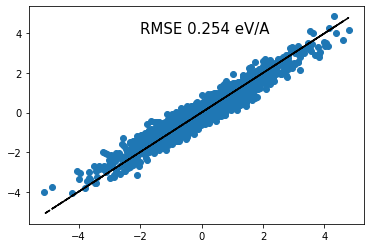

In [5]:
X = torch.from_numpy(val_features.dX_dr.reshape((val_features.dX_dr.shape[0], val_features.dX_dr.shape[2]*3))).float()#.cuda()
y_hat = net(X)
y_val = torch.from_numpy(f_val).float()
plt.scatter(y_val.detach().numpy(), y_hat.detach().numpy())
plt.plot(y_val.detach().numpy(), y_val.detach().numpy(), 'k--')
plt.text(-2, 4, "RMSE %.3f eV/A" %(torch.mean(torch.sum((y_hat - y_val)**2, axis =1)).detach().numpy())**0.5, fontsize = 15)
plt.show()

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.set = Data.TensorDataset(x, y)
        
    def __getitem__(self, index):
        data, target = self.set[index]        
        return data, target, index

    def __len__(self):
        return len(self.set)

In [ ]:
x = torch.from_numpy(tr_features.X).float()#.cuda()
y = torch.from_numpy(e_t.reshape(-1, 1)).float()#.cuda()
xf = [tr_features.dX_dr[s1:s2] for (s1, s2) in zip(tr_features.strides[:-1], tr_features.strides[1:])]
yf = [f_t[s1:s2] for (s1, s2) in zip(tr_features.strides[:-1], tr_features.strides[1:])]

x.requires_grad=True
net = torch.nn.Sequential(
        torch.nn.Linear(210, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    )#.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-5)
loss_en = torch.nn.MSELoss()  # this is for regression mean squared loss
loss_force = torch.nn.MSELoss()  # this is for regression mean squared loss

BATCH_SIZE = 32
EPOCH = 200

energy_dataset = MyDataset(x, y)
loader = Data.DataLoader(
    dataset=energy_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

    
# start training
for epoch in range(EPOCH):
    for step, (batch_x, batch_y, idx) in enumerate(loader): # for each training step
        b_x = Variable(batch_x)#.cuda()
        b_y = Variable(batch_y)#.cuda()
        pred_en = net(b_x)     # input x and predict based on x
        loss = loss_en(pred_en, b_y)     # must be (1. nn output, 2. target)
        for i, ii in enumerate(idx):
            grd = torch.zeros((1)) 
            pred_en[i].backward(gradient=grd, retain_graph=True)
            b_dx = torch.from_numpy(xf[ii])
            yf_pred = -torch.einsum('s, mcs -> mc', b_x[i].float(), b_dx.float())
            loss += loss_force(yf_pred, torch.from_numpy(yf[ii]).float())
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if epoch%10 == 0:
        print(loss)

tensor(1.0001e+12, grad_fn=<AddBackward0>)
tensor(1.8360e+12, grad_fn=<AddBackward0>)
tensor(7.4376e+11, grad_fn=<AddBackward0>)
tensor(6.1416e+11, grad_fn=<AddBackward0>)
tensor(1.7776e+11, grad_fn=<AddBackward0>)
tensor(2.4074e+11, grad_fn=<AddBackward0>)
tensor(1.1230e+11, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [197]:
a = [1, 5, 4, 10, 3, 3, 7]
target = 7
d = { i : ii for ii, i in enumerate(a)}
for i in d.keys():
    try:
        print(d[i], d[7-i])
        break
    except:
        pass

2 5


In [198]:
a.extend([0]*10)
a

[1, 5, 4, 10, 3, 3, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [162]:
X = torch.from_numpy(val_features.X).float()#.cuda()
y_hat = net(X)
y_val = torch.from_numpy(e_val).float()
plt.scatter(y_val.detach().numpy(), y_hat.detach().numpy())
plt.plot(y_val.detach().numpy(), y_val.detach().numpy(), 'k--')
plt.text(-2, 4, "RMSE %.3f eV/A" %(torch.mean(torch.sum((y_hat - y_val)**2, axis =1)).detach().numpy())**0.5, fontsize = 15)
plt.show()

SyntaxError: invalid syntax (<ipython-input-162-b84e432485b5>, line 1)